Class                                           1.000000
Long_Term_Fuel_Trim_Bank1                       0.379116
Engine_soacking_time                            0.186852
Engine_coolant_temperature.1                    0.144845
Torque_converter_turbine_speed_-_Unfiltered     0.114873
Torque_of_friction                              0.110172
Torque_converter_speed                          0.106669
Time(s)                                         0.097871
Engine_coolant_temperature                      0.075061
Accelerator_Pedal_value                         0.055409
Current_spark_timing                            0.048011
Engine_speed                                    0.035787
Flywheel_torque_(after_torque_interventions)    0.027184
Flywheel_torque                                 0.021356
Maximum_indicated_engine_torque                 0.018246
Activation_of_Air_compressor                    0.015651
Engine_Idel_Target_Speed                        0.015181
Steering_wheel_angle           

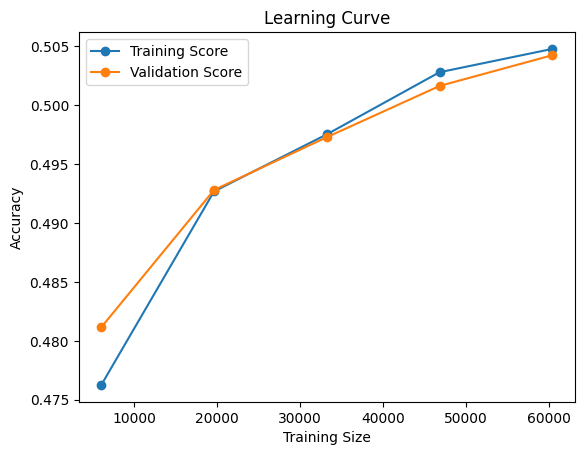

['driver_identification_model_rfe_lr.pkl']

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import joblib

# Load the dataset
data = pd.read_csv('c:/Users/USER/Documents/Data Science Journy/StackingOptimization/driving_data.csv')

# Assume target variable is in between, adjust accordingly
target_column = 'Class'  # Replace with the actual target column name
X = data.drop(columns=[target_column])  # Features
y = data[target_column]   # Target (Driver ID)

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Encode categorical features if any
categorical_columns = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_columns)

# Check for feature correlation with target
correlation_matrix = data.apply(lambda x: pd.factorize(x)[0]).corr()
print(correlation_matrix[target_column].sort_values(ascending=False))

# Remove highly correlated features (Threshold: 0.9)
high_correlation_features = correlation_matrix[target_column][correlation_matrix[target_column].abs() > 0.9].index.tolist()
high_correlation_features.remove(target_column)  # Remove target from the list
X = X.drop(columns=high_correlation_features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Feature Selection using Recursive Feature Elimination (RFE) with Random Forest
base_model_for_rfe = RandomForestClassifier(n_estimators=100, random_state=42)
n_features_to_select = 10  # Adjust based on dataset
rfe = RFE(estimator=base_model_for_rfe, n_features_to_select=n_features_to_select)

pipeline = Pipeline(steps=[('feature_selection', rfe), ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))])

# Perform cross-validation to check for overfitting
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Fit RFE on the training data
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Get the selected feature indices
selected_features = rfe.support_
print("Selected Features:", selected_features)

# Print the names of the selected features (if feature names are available)
feature_names = X.columns  # Use correct feature names
selected_feature_names = feature_names[selected_features]
print("Selected Feature Names:", selected_feature_names.tolist())

# Define Logistic Regression classifier
logistic_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Train the Logistic Regression classifier on the selected features
logistic_classifier.fit(X_train_rfe, y_train)

# Make predictions on the test set
y_pred = logistic_classifier.predict(X_test_rfe)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy after RFE: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Check training vs. test accuracy
train_accuracy = accuracy_score(y_train, logistic_classifier.predict(X_train_rfe))
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot Learning Curve
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='accuracy')
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training Score')
    plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label='Validation Score')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Learning Curve')
    plt.show()

plot_learning_curve(logistic_classifier, X_train_rfe, y_train)

# Save the model
joblib.dump(logistic_classifier, 'driver_identification_model_rfe_lr.pkl')
